# Mutational Clustering

Computes multichain mutational clustering
>Input files:
* Structure pdb file (cleaned or not)
* Cosmic *.csv* file from https://cancer.sanger.ac.uk/cosmic
>> *Gene page-> Variants-> Mutations -> Export: csv*
* Consurf *.txt* file from https://consurf.tau.ac.il/consurf_index.php
>> *Launch job-> View results summary (download)*

> Input variables
* Consurf file sequence reading option:
>>* s for SEQRES derived sequence
>>* a for ATOM derived sequence
* Output name
* Output directory pathname
* Required chain for plotting

> Output variables
* Count = number of total mutations from Cosmic *.csv* file
* Variants = number of variants from Cosmic *.csv* file
* CS Score = conservation score from Consurf *.txt* file
* W1 Score = Count * CS score /20
* Neighbs = number of neighboring residues within 8 Å cutoff
* M Neighbs = number of mutated neighbors
* Neigh Muts = number of total mutations on neighbors
* W2 Score = CS score / 9 * Neigh Muts
* W2 Score = normalized W2 Score










In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import time
#start_time= time.time ()
import pandas as pd
import numpy as np
import re
from collections import OrderedDict
from scipy.spatial import distance

pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)
#pd.reset_option('all')

In [ ]:
#with open ('/Users/federicopozzani/Desktop/Lab/Notebooks/Clustering/6ulg.pdb', 'r') as fin:
filein= input ('Enter PDB file pathname:\n')
with open (filein, 'r') as fin:
    wholepdb=fin

    colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

    names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

    pdb = pd.read_fwf(wholepdb, names=names, colspecs=colspecs)

    pdb = pdb.loc[pdb['ATOM'] == 'ATOM']
    pdb = pdb.loc[pdb['name'] == 'CA']
    pdb = pdb.loc[(pdb['altloc'].isna()) | (pdb['altloc']== 'A')]
    pdb = pdb.set_index('resseq')
    pdb.index = pdb.index.astype(int)

pdb.head()

Enter PDB file pathname:
/content/gdrive/MyDrive/5-LOX/5lox_model.pdb


,ATOM,serial,name,altloc,resname,chainid,icode,x,y,z,occupancy,tempfactor,element,charge
resseq,,,,,,,,,,,,,,
2,ATOM,2,CA,NaN,PRO,A,NaN,-27.828,-19.690,14.526,1.00,0.85,C,NaN
3,ATOM,9,CA,NaN,SER,A,NaN,-28.362,-20.203,10.762,1.00,0.85,C,NaN
4,ATOM,15,CA,NaN,TYR,A,NaN,-26.900,-21.968,7.730,1.00,0.91,C,NaN
5,ATOM,27,CA,NaN,THR,A,NaN,-27.095,-20.434,4.256,1.00,0.93,C,NaN
6,ATOM,34,CA,NaN,VAL,A,NaN,-28.073,-23.399,2.022,1.00,0.93,C,NaN


In [ ]:
""" .csv mutation export file in """

def opencsv(fin, chain):
    mut=pd.read_csv(fin, index_col=0)

    # dropping the rows having NaN index values

    mut = mut[mut.index.notnull()]
    mut.index = mut.index.astype(int)
    mut = mut.drop(labels=['CDS Mutation', 'AA Mutation', 'Legacy Mutation ID'], axis=1)

    # selecting for Missense
    mut = mut.loc[mut['Type'].str.contains('Missense')]
    mut = mut.drop(labels=['Type'], axis=1)

    # adding Variants column
    mut['Variants'] = 1

    # grouping and summing variants
    mut_= mut.groupby(['Position'])[['Count', 'Variants']].sum()

    # filling missing residues by PDB index with 0
    idx= grouped.get_group(chain).index
    cv=mut_.reindex(idx, fill_value=0)
    cv.index.names=['Residue']

    cv.insert(loc=0, column='Chain', value=grouped.get_group(chain)['chainid'])
    cv.index=cv.index.astype(int)

    return (cv, mut_)

#cv, mut_=opencsv(fin)

In [ ]:
grouped = pdb.groupby(pdb['chainid'], sort=False)
#grouped.get_group('L')


#pdb['chainid'].unique()
#print(len(grouped))
#x, y= grouped
#eug=x[1]

chains=[]
for name,group in grouped:
    chains.append(name)

chains

['A']

In [ ]:
opt= input('Select consurf file sequence reading option:\n\ts for SEQRES derived sequence\n\ta for ATOM derived sequence\n\t')
if opt != 's' and opt != 'a':
    raise ValueError('Please type "s" (SEQRES) or "a" (ATOM)')

def openconsurf (filein):
    mylist= list (filein)
    mutlist = [line.rstrip ('\n') for line in mylist]
    for ele in mutlist:
      if '(normalized)' in ele:
        cut= mutlist.index(ele)+1

    del mutlist[:cut]
    del mutlist[-4:]


    def delim():
        split=[]

        for ele in mutlist:
            delimiter='\t'
            t=ele.split(delimiter)
            if '-' not in t[2]:
                if opt=='s':
                  a=t[0].strip(' '), t[5].strip(' *')
                if opt=='a':
                  res= re.search('\d+',t[2])
                  a=int(res.group()), t[5].strip(' *')
                split.append(a)

        return split

    mcs= (delim())

    mc= pd.DataFrame(mcs, columns=['Residue', 'CS score'])
    mc['CS score'] = mc['CS score'].astype(int)
    mc=mc.set_index("Residue")
    mc.index=mc.index.astype(int)

    return (mc)

#mc= openconsurf (fin)

Select consurf file sequence reading option:
	s for SEQRES derived sequence
	a for ATOM derived sequence
	a


In [ ]:
df_dict=OrderedDict()
mut_dict=OrderedDict()
for ele in chains:

    csvin= input ('Enter mutation .csv file path for chain {}:\n'.format(ele))
    with open (csvin, 'r') as fin:
     cv, mut_= opencsv(fin, ele)


    consurfin= input ('Enter consurf .txt file path for chain {}:\n'.format(ele))
    with open (consurfin, 'r') as fin:
      mc= openconsurf(fin)

    cvc= pd.concat ([cv, mc], axis=1)
    cvc.index.name = None

    cvc['W1 score']=(cvc['Count']*cvc['CS score'])/20

    df_dict[ele] = cvc
    mut_dict[ele] = mut_



Enter mutation .csv file path for chain A:
/content/gdrive/MyDrive/5-LOX/ALOX5.csv
Enter consurf .txt file path for chain A:
/content/gdrive/MyDrive/5-LOX/consurf_5lox_model.txt


In [ ]:
""" concatenate all dataframes """

compw1= pd.concat (df_dict.values())
#compw1


In [ ]:
compw1=compw1.dropna()
compw1

,Chain,Count,Variants,CS score,W1 score
2,A,0,0,8,0.00
3,A,0,0,4,0.00
4,A,0,0,9,0.00
5,A,1,1,4,0.20
6,A,0,0,7,0.00
7,A,0,0,6,0.00
8,A,0,0,8,0.00
9,A,0,0,5,0.00
10,A,0,0,9,0.00
11,A,0,0,6,0.00


In [ ]:
multins=compw1.set_index(['Chain', compw1.index], drop=True)

multis=multins.sort_index()
multins

Count  Variants  CS score  W1 score
Chain                                         
A     2        0         0         8      0.00
      3        0         0         4      0.00
      4        0         0         9      0.00
      5        1         1         4      0.20
      6        0         0         7      0.00
      7        0         0         6      0.00
      8        0         0         8      0.00
      9        0         0         5      0.00
      10       0         0         9      0.00
      11       0         0         6      0.00
      12       1         1         3      0.15
      13       0         0         4      0.00
      14       0         0         1      0.00
      15       0         0         1      0.00
      16       1         1         7      0.35
      17       0         0         6      0.00
      18       0         0         9      0.00
      19       1         1         1      0.05
      20       0         0         7      0.00
      21       1         1         4      0.20
      22       0         0         6      0.00
      23       0         0         5      0.00
      24       0         0         6      0.00
      25       0         0         7      0.00
      26       0         0         8      0.00
      27       0         0         6      0.00
      28       1         1         9      0.45
      29       0         0         5      0.00
      30       0         0         4      0.00
      31       0         0         7      0.00
      32       0         0         6      0.00
      33       0         0         8      0.00
      34       0         0         4      0.00
      35       0         0         4      0.00
      36       1         1         4      0.20
      37       0         0         2      0.00
      38       0         0         7      0.00
      39       0         0         4      0.00
      40       0         0         4      0.00
      41       0         0         1      0.00
      42       0         0         4      0.00
      43       0         0         4      0.00
      44       0         0         2      0.00
      45       0         0         3      0.00
      46       1         1         6      0.30
      47       0         0         2      0.00
      48       0         0         3      0.00
      49       0         0         7      0.00
      50       1         1         4      0.20
      51       1         1         4      0.20
      52       0         0         4      0.00
      53       2         1         4      0.40
      54       0         0         5      0.00
      55       1         1         4      0.20
      56       0         0         6      0.00
      57       0         0         3      0.00
      58       0         0         5      0.00
      59       2         1         1      0.10
      60       3         2         2      0.30
      61       1         1         5      0.25
      62       0         0         7      0.00
      63       3         3         9      1.35
      64       3         2         3      0.45
      65       0         0         7      0.00
      66       0         0         4      0.00
      67       0         0         6      0.00
      68       0         0         7      0.00
      69       0         0         7      0.00
      70       0         0         7      0.00
      71       1         1         6      0.30
      72       0         0         8      0.00
      73       2         1         4      0.40
      74       0         0         3      0.00
      75       0         0         2      0.00
      76       2         1         3      0.30
      77       0         0         3      0.00
      78       0         0         4      0.00
      79       0         0         6      0.00
      80       1         1         5      0.25
      81       0         0         9      0.00
      82       0         0         7      0.00
      83       1         1         7      0.35
      84       0         0         5      0.00
      85       0

In [ ]:
pdbs=pdb.set_index(['chainid', pdb.index], drop=True)
pdbs=pdbs.sort_index()
pdbs

ATOM serial name altloc resname icode        x        y  \
chainid resseq                                                            
A       2       ATOM      2   CA    NaN     PRO   NaN  -27.828  -19.690   
        3       ATOM      9   CA    NaN     SER   NaN  -28.362  -20.203   
        4       ATOM     15   CA    NaN     TYR   NaN  -26.900  -21.968   
        5       ATOM     27   CA    NaN     THR   NaN  -27.095  -20.434   
        6       ATOM     34   CA    NaN     VAL   NaN  -28.073  -23.399   
        7       ATOM     41   CA    NaN     THR   NaN  -27.507  -22.792   
        8       ATOM     48   CA    NaN     VAL   NaN  -28.980  -25.230   
        9       ATOM     55   CA    NaN     ALA   NaN  -28.075  -25.115   
        10      ATOM     60   CA    NaN     THR   NaN  -30.409  -26.572   
        11      ATOM     67   CA    NaN     GLY   NaN  -29.079  -27.946   
        12      ATOM     71   CA    NaN     SER   NaN  -29.115  -26.059   
        13      ATOM     77   CA    NaN     GLN   NaN  -30.566  -29.093   
        14      ATOM     86   CA    NaN     TRP   NaN  -34.018  -28.917   
        15      ATOM    100   CA    NaN     PHE   NaN  -35.911  -31.007   
        16      ATOM    111   CA    NaN     ALA   NaN  -33.567  -30.144   
        17      ATOM    116   CA    NaN     GLY   NaN  -36.309  -28.295   
        18      ATOM    120   CA    NaN     THR   NaN  -38.901  -29.717   
        19      ATOM    127   CA    NaN     ASP   NaN  -42.122  -28.607   
        20      ATOM    135   CA    NaN     ASP   NaN  -41.844  -31.448   
        21      ATOM    143   CA    NaN     TYR   NaN  -41.266  -30.919   
        22      ATOM    155   CA    NaN     ILE   NaN  -37.578  -30.797   
        23      ATOM    163   CA    NaN     TYR   NaN  -36.519  -31.511   
        24      ATOM    175   CA    NaN     LEU   NaN  -33.005  -31.068   
        25      ATOM    183   CA    NaN     SER   NaN  -31.267  -32.286   
        26      ATOM    189   CA    NaN     LEU   NaN  -27.692  -31.661   
        27      ATOM    197   CA    NaN     VAL   NaN  -25.708  -34.476   
        28      ATOM    204   CA    NaN     GLY   NaN  -22.999  -33.215   
        29      ATOM    208   CA    NaN     SER   NaN  -20.586  -34.963   
        30      ATOM    214   CA    NaN     ALA   NaN  -22.420  -33.836   
        31      ATOM    219   CA    NaN     GLY   NaN  -25.918  -34.525   
        32      ATOM    223   CA    NaN     CYS   NaN  -28.264  -34.239   
        33      ATOM    229   CA    NaN     SER   NaN  -30.669  -31.393   
        34      ATOM    235   CA    NaN     GLU   NaN  -34.427  -31.621   
        35      ATOM    244   CA    NaN     LYS   NaN  -36.001  -32.148   
        36      ATOM    253   CA    NaN     HIS   NaN  -36.418  -28.630   
        37      ATOM    263   CA    NaN     LEU   NaN  -38.945  -28.309   
        38      ATOM    271   CA    NaN     LEU   NaN  -37.660  -25.932   
        39      ATOM    279   CA    NaN     ASP   NaN  -41.066  -25.237   
        40      ATOM    287   CA    NaN     LYS   NaN  -41.684  -21.725   
        41      ATOM    296   CA    NaN     PRO   NaN  -38.073  -20.581   
        42      ATOM    303   CA    NaN     PHE   NaN  -38.367  -22.035   
        43      ATOM    314   CA    NaN     TYR   NaN  -42.021  -20.863   
        44      ATOM    326   CA    NaN     ASN   NaN  -43.165  -24.352   
        45      ATOM    334   CA    NaN     ASP   NaN  -40.777  -24.660   
        46      ATOM    342   CA    NaN     PHE   NaN  -36.927  -25.044   
        47      ATOM    353   CA    NaN     GLU   NaN  -36.477  -23.655   
        48      ATOM    362   CA    NaN     ARG   NaN  -33.687  -24.787   
        49      ATOM    373   CA    NaN     GLY   NaN  -30.341  -22.932   
        50      ATOM    377   CA    NaN     ALA   NaN  -31.596  -21.332   
        51      ATOM    382   CA    NaN     VAL   NaN  -29.808  -21.068   
        52      ATOM    389   CA    NaN     ASP   NaN  -31.884  -20.883   
        53      ATOM    397   CA    NaN  

In [ ]:
outname = input ('enter output name:\n')
outdir = input ('enter output directory pathname:\n')

enter output name:
5-lox
enter output directory pathname:
/content/gdrive/MyDrive/5-LOX/clustering_out


In [ ]:
""" write vmd W1 score visualization state """

def writevmd ():
    data = {
        'form1': ' draw sphere "',
        'x': pdbs['x'],
        'y': pdbs['y'],
        'z': pdbs['z'],
        'form2': ' " ',
        'form3': 'radius',
        'W score': multis['W1 score'],
        'form4': 'resolution 20'
    }


    vmd=pd.DataFrame(data=data)
    vmd=vmd.dropna()
    #vmd.index.name = None

    vmdout= open('{}/{}_w1.vmd'.format(outdir, outname), 'w')
    hd=  ' molecule new\n display resetview\n draw color orange\n'
    vmdout.write(hd+vmd.to_string(header= False, index=False))
    vmdout.close()

writevmd()

In [ ]:
""" neighboring residues """

data= {
    'chainid': pdb['chainid'],
    'x': pdb['x'],
    'y': pdb['y'],
    'z': pdb['z']}

coo=pd.DataFrame(data=data, index=pdb.index)
coo=coo.set_index(['chainid',pdb.index.astype(int)], drop= True)
coo=coo.sort_index()
coo

x        y        z
chainid resseq                           
A       2       -27.828  -19.690   14.526
        3       -28.362  -20.203   10.762
        4       -26.900  -21.968    7.730
        5       -27.095  -20.434    4.256
        6       -28.073  -23.399    2.022
        7       -27.507  -22.792   -1.718
        8       -28.980  -25.230   -4.258
        9       -28.075  -25.115   -7.976
        10      -30.409  -26.572  -10.667
        11      -29.079  -27.946  -13.992
        12      -29.115  -26.059  -17.307
        13      -30.566  -29.093  -19.132
        14      -34.018  -28.917  -20.752
        15      -35.911  -31.007  -18.190
        16      -33.567  -30.144  -15.296
        17      -36.309  -28.295  -13.377
        18      -38.901  -29.717  -10.996
        19      -42.122  -28.607   -9.334
        20      -41.844  -31.448   -6.683
        21      -41.266  -30.919   -2.909
        22      -37.578  -30.797   -1.921
        23      -36.519  -31.511    1.655
        24      -33.005  -31.068    3.007
        25      -31.267  -32.286    6.189
        26      -27.692  -31.661    7.340
        27      -25.708  -34.476    8.971
        28      -22.999  -33.215   11.324
        29      -20.586  -34.963   13.673
        30      -22.420  -33.836   16.829
        31      -25.918  -34.525   15.451
        32      -28.264  -34.239   12.479
        33      -30.669  -31.393   11.664
        34      -34.427  -31.621   11.118
        35      -36.001  -32.148    7.685
        36      -36.418  -28.630    6.304
        37      -38.945  -28.309    3.480
        38      -37.660  -25.932    0.744
        39      -41.066  -25.237   -1.018
        40      -41.684  -21.725    0.277
        41      -38.073  -20.581   -0.784
        42      -38.367  -22.035   -4.294
        43      -42.021  -20.863   -4.856
        44      -43.165  -24.352   -5.973
        45      -40.777  -24.660   -9.015
        46      -36.927  -25.044   -9.197
        47      -36.477  -23.655  -12.714
        48      -33.687  -24.787  -15.102
        49      -30.341  -22.932  -14.698
        50      -31.596  -21.332  -11.483
        51      -29.808  -21.068   -8.143
        52      -31.884  -20.883   -4.980
        53      -30.582  -19.968   -1.460
        54      -31.981  -20.335    2.008
        55      -31.512  -19.241    5.620
        56      -31.988  -22.437    7.663
        57      -31.965  -22.165   11.473
        58      -31.071  -25.318   13.429
        59      -32.391  -26.297   16.884
        60      -29.140  -27.923   18.161
        61      -25.352  -27.654   17.541
        62      -24.443  -29.991   14.656
        63      -20.625  -29.690   14.894
        64      -18.689  -30.217   11.636
        65      -21.048  -30.890    8.685
        66      -20.204  -34.253    7.078
        67      -23.148  -35.145    4.823
        68      -26.057  -33.370    3.138
        69      -29.271  -35.353    2.608
        70      -31.625  -34.282   -0.195
        71      -35.083  -35.845   -0.339
        72      -37.575  -35.325   -3.180
        73      -41.276  -35.932   -2.521
        74      -43.924  -35.892   -5.244
        75      -46.401  -33.129   -6.204
        76      -48.644  -33.970   -9.255
        77      -46.819  -36.029  -12.003
        78      -43.108  -36.983  -11.649
        79      -40.714  -34.275  -12.920
        80      -36.980  -35.265  -12.973
        81      -34.687  -32.826  -11.122
        82      -31.020  -32.240  -12.014
        83      -29.083  -31.090   -8.960
        84      -25.677  -29.654   -9.872
        85      -24.285  -28.841   -6.430
        86      -25.102  -27.605   -2.927
        87      -23.095  -25.004   -0.966
        88      -23.301  -24.321    2.762
        89      -22.315  -21.248    4.709
        90      -21.971  -22.213    8.415
        91      -22.580  -20.021   11.547
        92      -18.826  -20.258   12.204
        93      -17.983  -18.736    8.824
        94      -17.063  -21.913    6.973
        95      -17.845  -22.412

In [ ]:
#mfa= coo.loc[('G', 368):('L', 4), :]
#mic= mfa.to_numpy()
#mfa

In [ ]:
""" matrix parsing function """

def ret(din):
    d= {} #number of neighbors
    dn= {} #number of mut neighbors
    l= [] #neigh pairs
    df= {} #sum of mutation frequencies on neighbors
    for key, value in (din).items():
        d[key]=0
        dn[key]=0
        df[key]=0
        for n in (din.index):
            if (value[n])>8 or (value[n]) == 0:
                continue
            else:
                d[key] += 1
                m = (n, key)
                l.append(m)

                if multis.loc[n, 'Count'] != 0:
                    dn[key] += 1
                    df[key] += multis.loc[n, 'Count']

            #print (value[n], 'row', n, 'col', key)
            #print (d)
        #print ('residue:', key)
        #print ('neigh=', d[key])
    return (d, l, dn, df)

#ret(fos)

In [ ]:
""" test for neighboring matrix """

#from scipy.spatial import distance


#foo=distance.cdist(mic, mic, 'euclidean')

#fos=pd.DataFrame(foo, columns=(mfa.index), index=(mfa.index))

#print (fos, '\n\n')
#fos

' test for neighboring matrix '

In [ ]:
#neighcount, neigh, mutneighcount, neighfreqs= ret(fos)

In [ ]:
""" building neighboring matrix """
coo=coo.astype(float)
boom= coo.loc[:, ['x','y','z']].to_numpy()
#dbr=pd.DataFrame(boom, columns=['x', 'y', 'z'], index=pdb.index)

mat=distance.cdist(boom, boom, 'euclidean')

matr=pd.DataFrame(mat, columns=coo.index, index=coo.index)

In [ ]:
neighcount, neigh, mutneighcount, neighfreqs= ret(matr)

In [ ]:
multis['Neighbs']=neighcount.values() #number of neighbors
multis['M Neighbs']= mutneighcount.values() #number of mut neighbors
multis['Neigh Muts']= neighfreqs.values() #sum of mutation frequencies on neighbors
multis['W2 Score']= ((multis['CS score']/9)*multis['Neigh Muts']).round(2)

for key, value in multis['W2 Score'].items():
    if multis.loc[key,'Count'] == 0:
        multis.loc[key,'W2 Score'] = 0

w2= multis['W2 Score']
multis['W2 Norm']= ((w2 - w2.min()) / (w2.max() - (w2.min())) * 100).round(2)

In [ ]:
""" export clustering text file """

def multiout():
    multis.index.name = 'Res'
    multiout= open('{}/{}_clustering.txt'.format(outdir, outname), 'w')
    out= multis.to_string()
    multiout.write(out)
    multiout.close()

multiout()

In [ ]:
""" export clustering sort by w1 """
def sortw1out():
    sortw1=multis.sort_values(by=['W1 score'], ascending=False)
    sortw1out= open('{}/{}_sort_w1.txt'.format(outdir, outname), 'w')
    out= sortw1.to_string()
    sortw1out.write(out)
    sortw1out.close()

sortw1out()

In [ ]:
def sortw2out():
    sortw2=multis.sort_values(by=['W2 Score'], ascending=False)
    sortw2out= open('{}/{}_sort_w2.txt'.format(outdir, outname), 'w')
    out= sortw2.to_string()
    sortw2out.write(out)
    sortw2out.close()

sortw2out()

In [ ]:
def sortcount():
    sortc=multis.sort_values(by=['Count'], ascending=False)
    sortcount= open('{}/{}_sort_count.txt'.format(outdir, outname), 'w')
    out= sortc.to_string()
    sortcount.write(out)
    sortcount.close()

sortcount()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
pchain= input ('Input required chain for plotting\n')
pmultis= multis.reset_index(level=[0,1])
pmultis.rename(columns = {'level_1':'Residue'}, inplace= True)


Input required chain for plotting
A


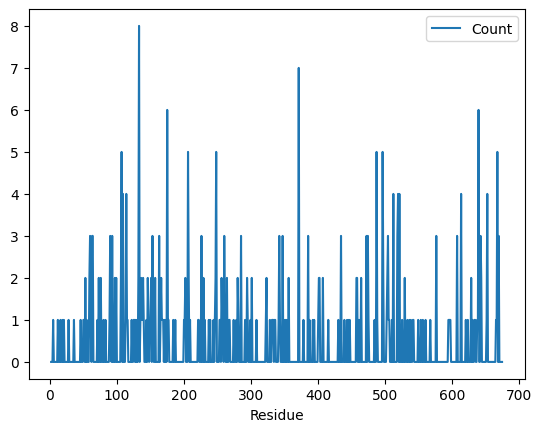

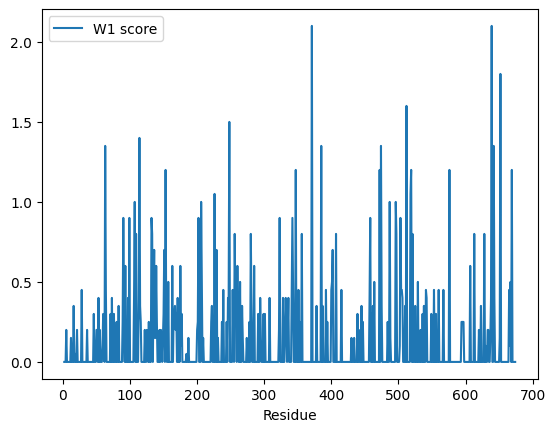

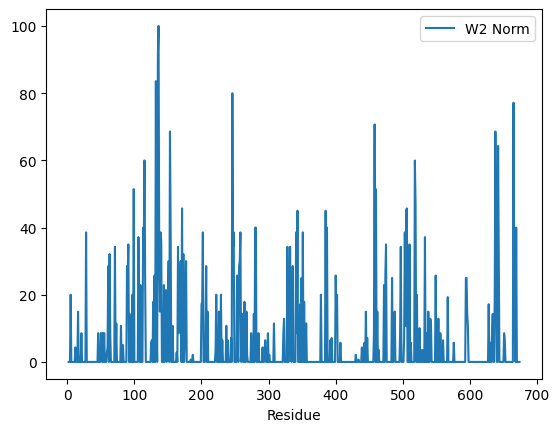

In [ ]:
mgj=pmultis[pmultis['Chain']== pchain]
pcount=mgj.plot(y='Count', x= 'Residue')
fout= '{}/{}_plot_count_chain{}.png'.format(outdir, outname, pchain)
plt.savefig(fout, dpi=300, facecolor='white', bbox_inches='tight')

pw1=mgj.plot(y='W1 score', x= 'Residue')
fout= '{}/{}_plot_w1_chain{}.png'.format(outdir, outname, pchain)
plt.savefig(fout, dpi=300, facecolor='white', bbox_inches='tight')

pw2=mgj.plot(y='W2 Norm', x= 'Residue')
fout= '{}/{}_plot_w2_chain{}.png'.format(outdir, outname, pchain)
plt.savefig(fout, dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
pdbw2= pdb
pdbw2= pdbw2.set_index(['chainid', pdb.index], drop=False)
pdbw2= pdbw2.sort_index()
mf=pdbw2.index.get_level_values(1)
pdbw2.insert(loc=6, column='res', value=mf)
pdbw2=pdbw2.drop(labels=['element', 'charge', 'altloc'], axis=1)
pdbw2['tempfactor']=multis['W2 Norm']
pdbw2['icode']='  '
pdbw2['occupancy']='1.00'
pdbw2= pdbw2.loc[pdbw2['tempfactor'] != 0]
pdbw2['serial']=pdbw2['serial'].astype(int)
pdbw2=pdbw2.sort_values('serial')
pdbw2.head()

ATOM  serial name resname chainid  res icode        x  \
chainid resseq                                                          
A       5       ATOM      27   CA     THR       A    5        -27.095   
        12      ATOM      71   CA     SER       A   12        -29.115   
        16      ATOM     111   CA     ALA       A   16        -33.567   
        19      ATOM     127   CA     ASP       A   19        -42.122   
        21      ATOM     143   CA     TYR       A   21        -41.266   

                      y        z occupancy  tempfactor  
chainid resseq                                          
A       5       -20.434    4.256      1.00       19.99  
        12      -26.059  -17.307      1.00        4.31  
        16      -30.144  -15.296      1.00       14.97  
        19      -28.607   -9.334      1.00        1.41  
        21      -30.919   -2.909      1.00        8.55

In [ ]:
def pdbw2out():
    pdbwout= open('{}/{}_w2.pdb'.format(outdir, outname), 'w')
    col_space= {'serial':6, 'name':3, 'resname':4, 'occupancy':5, 'tempfactor':5}
    out= pdbw2.to_string(col_space=col_space, header= False, index=False)
    pdbwout.write(out)
    pdbwout.close()

pdbw2out()